### Multilayer Neural Networks

Instructor: Nedelina Teneva <br>



Citations: <br>

 - Chapter 12, 13: Python Machine Learning 3rd Edition by [Sebastian Raschka](https://sebastianraschka.com), Packt Publishing Ltd. 2019
 - https://www.tensorflow.org/tutorials/keras/classification
 - https://towardsdatascience.com/beginners-guide-to-building-neural-networks-in-tensorflow-dab7a09b941d
 - https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/activations
 - https://www.tensorflow.org/learn
 - https://www.youtube.com/watch?v=aircAruvnKk&t=1011s
 - Cornelia Ilin's prep material: https://github.com/MIDS-W207/cilin-coursework/tree/master/live_sessions

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

print(tf.__version__)

2.12.0


### Helper functions

In [2]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### Read data

We will train a multilayer NN model to classify images of clothing using the MNIST fashion dataset.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print('Shape of train_images', train_images.shape)
print('Shape of test_images', test_images.shape)
print('Labels in train_labels', np.unique(train_labels))
print('Labels in train_labels', np.unique(test_labels))

4422102/4422102 [==============================] - 0s 0us/step
Shape of train_images (60000, 28, 28)
Shape of test_images (10000, 28, 28)
Labels in train_labels [0 1 2 3 4 5 6 7 8 9]
Labels in train_labels [0 1 2 3 4 5 6 7 8 9]


There are 60,000 images in the training set and 10,000 images in the test set, with each image represented as 28 x 28 pixels:

Each image is mapped to a single integer label [0,9]. Class names are not included with the dataset, so we will store them manually here (they will be useful when we plot the images).

### Data preprocessing

define class names

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

scale pixel values to a range of 0 to 1

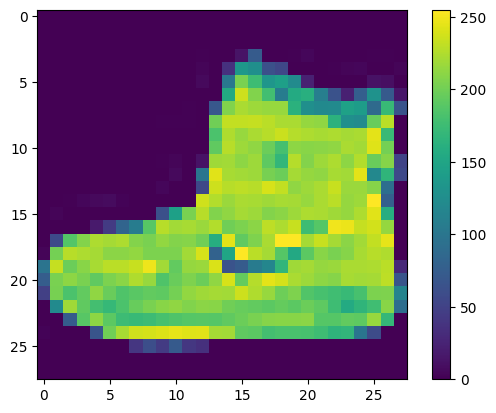

In [5]:
# this is a image before scaling
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
# scale train and test images
train_images = train_images / 255.0
test_images = test_images / 255.0

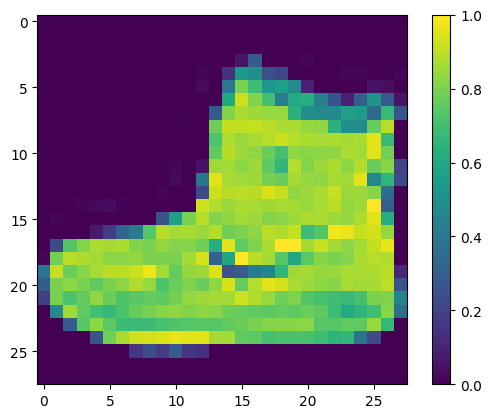

In [7]:
# this is an image after scaling
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

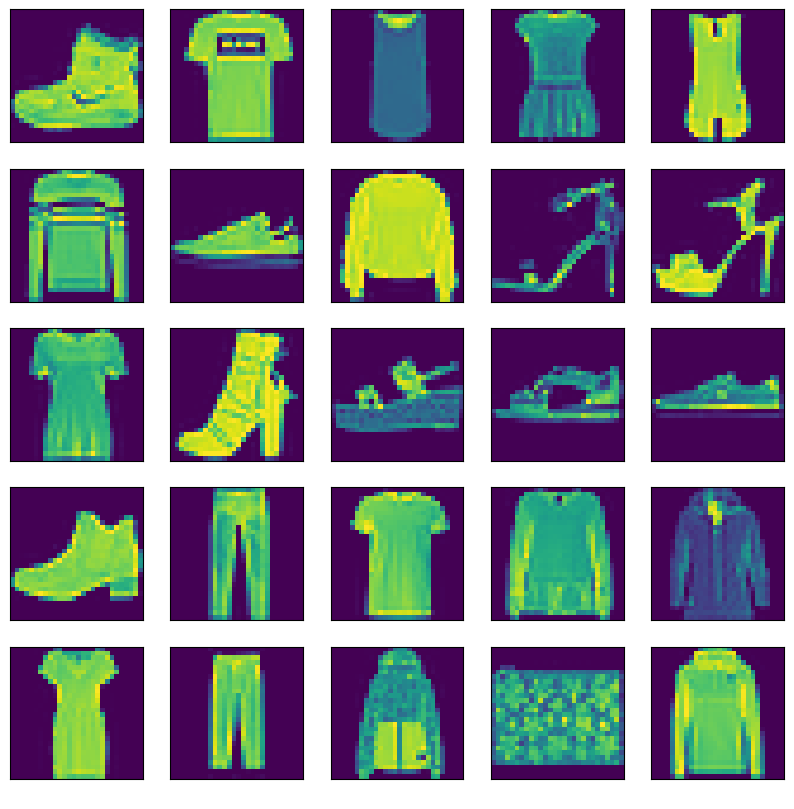

In [8]:
# let's actally display the first 25 images from the training dataset to make sure everything is corect
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    #plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]], color='white')
plt.show()

### Two layer Neural Net Training

#### 1. Build the NN model
(requires (a) configuring the layers of the model, and (b) compiling the model

In [9]:
model = keras.Sequential([
    # the First layer transforms the format of the images (to a 1D array of 28*28 = 784 pixels)
    # this layer has no params or weights to learn, it only reformats data
    keras.layers.Flatten(input_shape=(28, 28)),
    # the Second layer is a dense layer (i.e., the nodes are fully connected)
    # this layer has 128 nodes, and it uses the activation function Rectified Linear Unit
    keras.layers.Dense(128, activation='relu'),
    # the Third layer is a dropout layer
    # makes it so some of the nodes in a given layer don’t pass on their information to the next layer. This helps with computation time (less parameters) and with overfitting.
    # each node in the second  layer has a 0.2 probability of being dropped from the computation of the activations of the next layer.
    keras.layers.Dropout(0.2),
    # the Fourth (and last) layer, which is the output layer, returns a logits array of length 10
    # each node contains a probability that indicates the current image belongs to one of the 10 classes
    # note that the size of the output layer is always equal with the number of classes in the dataset
    # it uses the activation function Softmax which is the equivalent of the Sigmoid function for multiclass logits
    keras.layers.Dense(10, activation='softmax')
])

In [10]:
# get information on parameters of the model. Note that these can be obtained from the computation graph without needing any data at all.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [11]:
# compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# The loss (cost) function for this particular model is ‘sparse_categorical_crossentropy’ which is good for multiclass-classification problems like this one.
# Check here for more optimizer options: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers

#### 2. Fit the NN model

In [12]:
history = model.fit(train_images, train_labels, epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 10s 5ms/step - loss: 0.8190 - accuracy: 0.7270
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5617 - accuracy: 0.8098
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.5040 - accuracy: 0.8281
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4723 - accuracy: 0.8367
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4485 - accuracy: 0.8433
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4335 - accuracy: 0.8495
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4185 - accuracy: 0.8535
Epoch 8/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4074 - accuracy: 0.8565
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3989 - accuracy: 0.8612
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3906 - accura

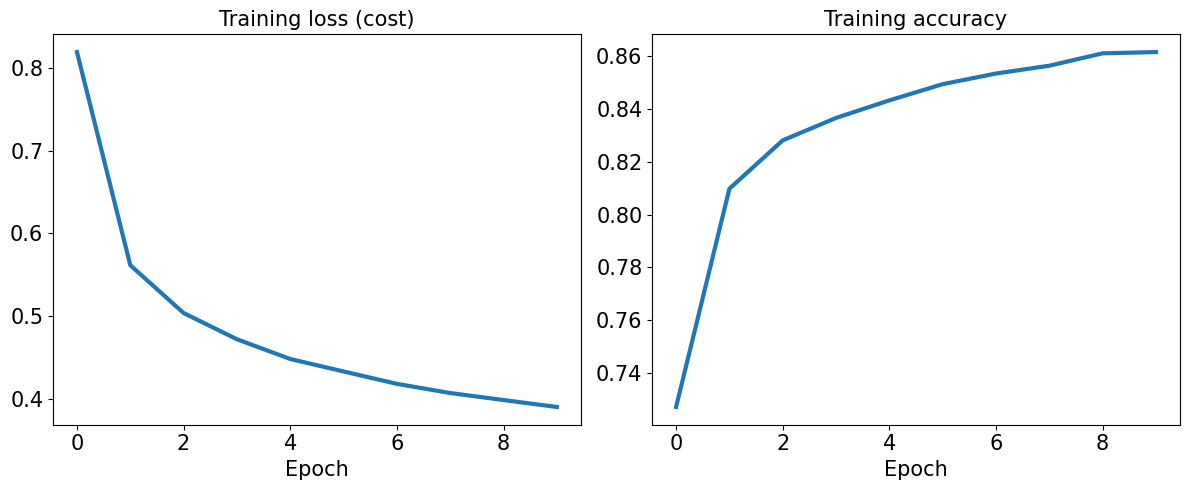

In [13]:
# plot training cost and accuracy
hist = history.history
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss (cost)', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()


#### 3. Evaluate accuracy on the test set

In [14]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.4074 - accuracy: 0.8565 - 716ms/epoch - 2ms/step

Test accuracy: 0.8565000295639038


#### 4. Inference and Error Analysis

In [15]:
predictions = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [16]:
# let's look at the predictions for the first image
print(predictions[0])

print("\nThe model thinks that the first image is", np.argmax(predictions[0]), ':', class_names[np.argmax(predictions[0])])

[1.9708739e-05 8.0604896e-06 9.6274653e-06 1.9303257e-05 6.4341308e-05
 7.9481959e-02 4.0092564e-05 1.3314666e-01 1.8509094e-03 7.8535926e-01]

The model thinks that the first image is 9 : Ankle boot


Let's now plot several images with their predictions. Note that the model can be wrong even when very confident.

Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

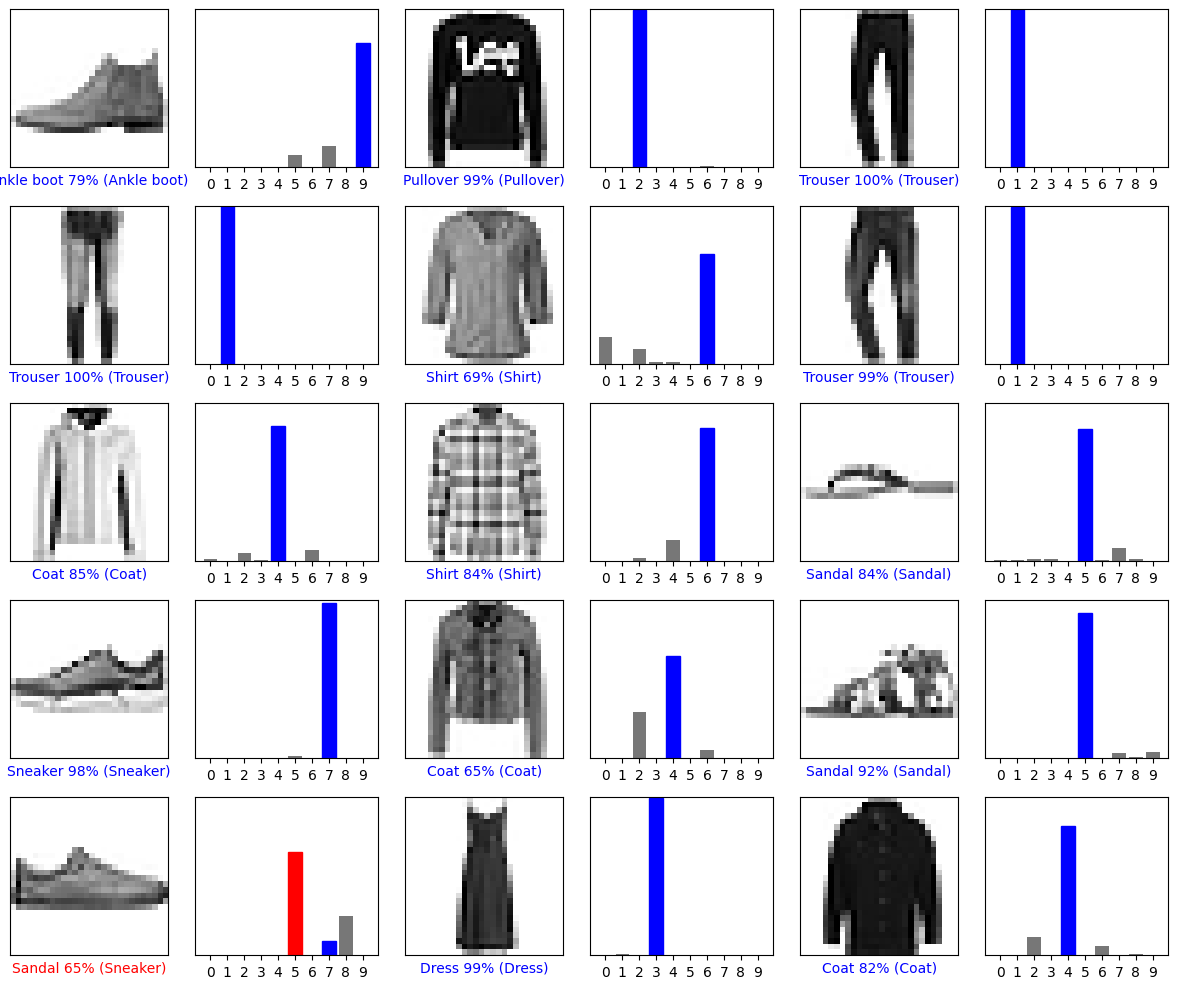

In [21]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

**Question 1**

Which class does the model gets wrong the most? What other class does the model confused it with? Can you find an intuitive explanation for this confusion?

*Extra*: Do the same for the second most confused class. Any intuition?

**Question 2**

Now try to change the number of hidden layers, the number of iterations (epochs), the number of nodes in the hidden layers. What's the impact?


**Question 3**

Keeping everything else fixed, what happens if you remove the dropout error (regularization in multilayer NN)? What happens if you decrease and increase the dropout probability?
